In [3]:
# TODO!: pb EROI_wo_GW ER/ADV and EROIs REF
# TODO: calculer EROIs en partant du foreground
# TODO: construire scénario carbon neutral:
#       - pour changer mix énergétique, reprendre code 'cleaner' dans eroi_exio.ipynb
#       - se baser sur greenpeace, comparer avec Luderer, et compléter avec WWF pour non élec
#       - comme scénarios: greenpeace (>appendix), ecosys (mix: appendix), Jackobson-Delucci, Luderer (GIEC, short), Garcia (energy, transport), 
# other:DDPP (country case studies and overall change in CO2 intensity, mix and electric cars), Denholm (grid), Chatzi (grid), Child (out but contains references)
# TODO: compléter rapport greenpeace par évaluation des émissions d'autres polluants (cf. Table 4 de Child et al 2018)
# TODO: - équilibrer les tables: sums cols != sums rows (--> GRAS) => pas possible, car on n'a pas de vecteur de demande ou de production (ARDA_file.xls absent)
#       - pythoniser, rendre fonctionnel et modulaire le code matlab 
#       - mettre à jour les données (Exiobase 2 ou 3, ecoinvent 3)
#       (- agréger secteurs/régions pour gagner en rapidité)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # 'last' 'none' ...

import pymrio
from pymrio.core.mriosystem import IOSystem
from pymrio.tools.iometadata import MRIOMetaData
from pymrio.tools.iofunctions import *
import numpy as np
import pandas as pd
import scipy.io
import scipy.sparse as sp 
from scipy.sparse import linalg as spla
import pickle
import time
import matplotlib.pyplot as plt
from openpyxl import load_workbook

In [4]:
path_themis = '/media/adrien/dd/adrien/DD/Économie/Données/Themis/'
path_io = '/media/adrien/dd/adrien/DD/Économie/Données/'

In [6]:
themis = pymrio.themis_parser(path_themis)

In [7]:
themis = pickle.load(open(path_io+'Themis/themis.pkl', 'rb'))

In [ ]:
themis = dict()
for s in ['BL', 'BM', 'REF', 'ER', 'ADV', 'combo']:
    themis[s] = pickle.load(open(path_io+'Themis/themis_'+s+'.pkl', 'rb'))

In [9]:
erois_prices = pickle.load(open(path_io+'Themis/erois_prices.pkl', 'rb'))
erois_prices_wo_GW = pickle.load(open(path_io+'Themis/erois_prices_wo_GW.pkl', 'rb'))

In [8]:
def themis_parser(exio_files, year = None, scenario = None, themis = None, themis_caracs=None, labels=None, dlr_files=None, combo=True, compute_all=False):
    """ THEMIS parser (by adrien fabre aka. bixiou on github)

    The THEMIS model is not open. You can ask NTNU for it, they might accept.

    Two options for this parser: 1. either provide the year (2010, 2030, or 2050) and scenario ('BL' or 'BM'),
                                 2. either provide none of them, and all combinations will be loaded in a dict
    exio_files must give the path to the root folder of THEMIS
    if dlr_files is provided, the 3 Greenpeace=DLR scenarios are added (in case 2.); dlr_files = True is equivalent to dlr_files = exio_files
    if combo = True and dlr_files is provided, create 3 'combo' scenarios (improperly named): 
        2010 : ADV 2050 mix on 2010 techno (i.e. 2010 transformation matrix A); 2030: ER 2050 mix on 2010 techno; 2050: BL 2010 mix on 2050 techno
    compute_all precalculates EROIs, prices, value-added, employments
    The folder should include a file called 'Supplementary info & mixes.xlsx' which provides the IEA scenarios of energy demand.
        You can ask this file to adrien.fabre@psemail.eu
    themis_parser runs in ~1h if combo=True and compute_all=True, ~1 min if they are false
    """
    
    def load_themis(matrix='A', year=2010, scenario='BL'):
        # matrix is A, Sb, Sf or S; year is 2010, 2030 or 2050; scenario is BL or BM
        if matrix=='S': 
            Sb = load_themis('Sb', year, scenario)
            Sf = load_themis('Sf', year, scenario)       
            nb_stressors_b = Sb.shape[0] - Sf.shape[0] # check .shape for sparse
            nb_sectors_f = Sf.shape[1]
            res = sp.hstack([sp.vstack([Sf, sp.csc_matrix((nb_stressors_b, nb_sectors_f))]), Sb])
        else:
            if matrix=='A': data = 'A'
            elif matrix=='Sb': data = 'S'
            elif matrix=='Sf': data = 'S_f'
            else: data = matrix

            year = '_' + str(year)
            if data=='S_f': matrix_name = data + '_' + scenario
            else: matrix_name = data + year + '_' + scenario

            if data=='S_f': res = themis[matrix_name][:,:,2]
            else: res = themis[matrix_name]
        return(res)  
    
    def secondary_energy_demand():
        TWh2TJ = 3.60 * 1e3
        secondary_energy_demand = np.array([0]*A.shape[0])
        for name in energy_demand.index: 
            if name in list(labels['sectors']):
                secondary_energy_demand[np.where(list(map(lambda s: s == name, labels['idx_sectors'])))[0]] = \
                    energy_demand[[(reg, year) for reg in labels['regions']]].loc[name] * TWh2TJ
        return(secondary_energy_demand)
    
    if themis is None or themis_caracs is None or labels is None: 
        themis = scipy.io.loadmat(exio_files + 'Data/THEMIS2.mat')
        themis_caracs = scipy.io.loadmat(exio_files + 'Data/Characterization_endpoint2.mat')
        label = pd.read_excel(exio_files + 'Data/THEMIS2_labels.xls', header=0)
        idx_name = label['Name']
        idx_region = label['Region']
        idx_region.loc[np.where(idx_region=='AME')] = 'Africa and Middle East'
        idx_region.loc[np.where(idx_region=='CN')] = 'China'
        idx_region.loc[np.where(idx_region=='EIT')] = 'Economies in transition'
        idx_region.loc[np.where(idx_region=='IN')] = 'India'
        idx_region.loc[np.where(idx_region=='LA')] = 'Latin America'
        idx_region.loc[np.where(idx_region=='PAC')] = 'OECD Pacific'
        idx_region.loc[np.where(idx_region=='US')] = 'OECD North America'
        idx_region.loc[np.where(idx_region=='RER')] = 'OECD Europe'
        idx_region.loc[np.where(idx_region=='AS')] = 'Rest of developing Asia'
        label2 = pd.read_excel(exio_files + 'Data/THEMIS2_labels.xls', header=0, sheet_name=2)
        idx_impacts = label2['FullName']
        label3 = pd.read_excel(exio_files + 'Data/THEMIS2_labels.xls', header=0, sheet_name=3)
        idx_caracs = label3['Abbreviation THEMIS']
        labels = {'regions': idx_region.unique(), 'idx_regions': idx_region, 'impacts': idx_impacts.unique(), 'idx_impacts': idx_impacts, 
                  'sectors': idx_name.unique(), 'idx_sectors': idx_name, 'caracs': idx_caracs.unique(), 'idx_caracs': idx_caracs, 'name': 'labels'}
    if year is None and scenario is None: 
        if dlr_files is not None: 
            if combo: scenarios = ['BL', 'BM', 'REF', 'ER', 'ADV', 'combo'] 
            else: scenarios = ['BL', 'BM', 'REF', 'ER', 'ADV']
            if type(dlr_files)!=str: dlr_files = exio_files
        else: scenarios = ['BL', 'BM']
        all_themis = dict()
        for s in scenarios:
            all_themis[s] = dict()
            for y in [2010, 2030, 2050]:
                if s == 'BL' or s == 'BM': 
                    all_themis[s][y] = themis_parser(exio_files, y, s, themis, themis_caracs, labels)
                    all_themis[s][y].scenario = s
                else:
                    if s == 'combo':
                        if y in [2010, 2030]: 
                            yr, not_yr, sc = 2010, 2050, 'ADV'
                            if y == 2030: sc = 'ER'
                            all_themis[s][y] = all_themis['BL'][yr].copy(new_name='THEMIS')
                            all_themis[s][y].dlr_elec = all_themis[sc][2050].dlr_elec
                            all_themis[s][y].dlr_capacity = all_themis[sc][2050].dlr_capacity
                            global_mix = all_themis[sc][not_yr].mix(scenario = sc, path_dlr = dlr_files)[y]
                        else: 
                            yr, not_yr, sc = 2050, 2010, 'BL'
                            all_themis[s][y] = all_themis['BL'][yr].copy(new_name='THEMIS')
                            global_mix = all_themis['BL'][2010].mix_matrix(global_mix = False)
                        all_themis[s][y].aggregate_mix(mix = global_mix)
                        all_themis[s][y].change_mix(global_mix = global_mix, year = not_yr, only_exiobase = False)
                        
                    elif s == 'REF': all_themis[s][y] = all_themis['BL'][y].copy(new_name='THEMIS') # TODO: include attribute scenario
                    else: all_themis[s][y] = all_themis['BM'][y].copy(new_name='THEMIS') 
                    all_themis[s][y].scenario = s
                    if s != 'combo':
                        global_mix = all_themis[s][2010].mix(scenario = s, path_dlr = dlr_files)[y]
                        all_themis[s][y].dlr_elec = all_themis[s][2010].dlr_elec
                        all_themis[s][y].dlr_capacity = all_themis[s][2010].dlr_capacity
                        all_themis[s][y].adjust_capacity = all_themis[s][2010].adjust_capacity
                        all_themis[s][y].adjustment_capacity = all_themis[s][2010].adjustment_capacity
                        if s in ['REF', 'ER', 'ADV']: 
                            all_themis[s][y].wo_GW_adj = all_themis[s][y].copy(new_name='THEMIS')
                            all_themis[s][y].wo_GW_adj.change_mix(global_mix = global_mix, year = y, only_exiobase = False, adjust_GW = False)
                        all_themis[s][y].change_mix(global_mix = global_mix, year = y, only_exiobase = False, adjust_GW=True)
        if compute_all:
            for s in scenarios:
                for y in [2010, 2030, 2050]:                  
                    if s=='combo' and y==2050: all_themis[s][y].world_mix = all_themis[s][y].agg_mix
                    else: all_themis[s][y].world_mix = all_themis[s][y].aggregate_mix(recompute=True)
                    if s in ['REF', 'ER', 'ADV']: 
                        all_themis[s][y].wo_GW_adj.eroi_adj = all_themis[s][y].wo_GW_adj.erois(factor_elec = 2.6, \
                                                                                               recompute=True).rename(index={'Power sector': 'total'})
                        all_themis[s][y].wo_GW_adj.eroi = all_themis[s][y].wo_GW_adj.erois(recompute=True).rename(index={'Power sector': 'total'})
                        all_themis[s][y].wo_GW_adj.energy_prices()
                        all_themis[s][y].wo_GW_adj.employ_direct = all_themis[s][y].wo_GW_adj.employments()
                        all_themis[s][y].wo_GW_adj.employments(indirect = False, recompute = True)
                    all_themis[s][y].eroi_adj = all_themis[s][y].erois(factor_elec = 2.6, recompute=True).rename(index={'Power sector': 'total'})
                    all_themis[s][y].eroi = all_themis[s][y].erois(recompute=True).rename(index={'Power sector': 'total'})
                    all_themis[s][y].energy_prices()
                    all_themis[s][y].employ_direct = all_themis[s][y].employments()
                    all_themis[s][y].employments(indirect = False, recompute = True) # pb with employments combo 2050

        return(all_themis)
    elif year is None or scenario is None: print('scenario and year must be both given or None')
    else:
        A = load_themis('A', year, scenario)
        S = load_themis('S', year, scenario)
        if scenario=='BL': skip, skipfoot = 6, 67 # TODO: make a separate function the extraction of IEA scenarios
        elif scenario=='BM': skip, skipfoot = 52, 21
        energy_demand = pd.read_excel(exio_files+'Supplementary info & mixes.xlsx', \
                                         header=[0,1], index_col=0, skiprows=list(range(skip)), skipfooter=skipfoot, sheet_name=11) #TODO: select good columns>?
        energy_demand.index = ['Electricity by ' + name[0].lower() + name[1:] for name in list(energy_demand.index)]
        if scenario=='BL': skip, skipfoot = 27, 46
        if scenario=='BM': skip, skipfoot = 73, 0
        capacity = pd.read_excel(exio_files+'Supplementary info & mixes.xlsx', \
                                         header=[0,1], index_col=0, skiprows=list(range(skip)), skipfooter=skipfoot, sheet_name=11)
        capacity.index = ['Electricity by ' + name[0].lower() + name[1:] for name in list(capacity.index)] # in GW
#         C = themis_caracs['C_H_CED_22'] # midpoint characterization
#         C_large = themis_caracs['C_H_CED_large'] # midpoint characterization taken by Thomas Gibon: should be preferred to C
#         C_index = themis_caracs['EP_H_CED_22']
#         G = themis_caracs['G_H_CED_22'] # endpoint characterization
#         G_index = themis_caracs['IMP_H_CED_22'] # cf. THEMIS2_labels.xls/C_IMP for more details
#         mid2end = themis_caracs['mid2end']
        meta_rec = MRIOMetaData(system='pxp', name='THEMIS', version=scenario)
        core_data = dict()
        extensions = {'labels':labels, 'impact': {'S': S, 'name': 'impact'}, 
                      'energy':{'demand': energy_demand, 'secondary_demand': secondary_energy_demand(), 'capacity': capacity, 'name': 'energy'}} 

        return IOSystem(A=A, name='THEMIS', version=scenario, year=year, meta=meta_rec, **dict(core_data, **extensions))

In [9]:
def results(themis, stats=['eroi', 'world_mix'], scenarios=['BL', 'BM', 'ADV'], to_plot = False, not_all_2010=True, rounded=True, fillNA=True, longnames=False,
            dlr_sectors=False, longtotal=True, year = None, extend_wo_GW = False): # TODO: re-order index, mix_real, specific region
    '''
    Returns a panda dataframe with results from stats and scenarios specified.
    stats can include: 'eroi', 'eroi_adj', 'eroi_wo_GW', 'eroi_wo_GW_adj', 'world_mix', 'employ', 'employ_direct', 'energy_price'
    scenarios can include: BL, BM, REF, ER, ADV, combo
    not_all_2010 keeps only one scenario for year 2010
    fillNA fills NaN with '–' instead of 0, rounded rounds the figures to max 2 digit, longnames details the scenario name, dlr_sectors removes CCS from sectors,
        longtotal puts 'Total (PWh/a)' instead of 'total' for the last index: all these parameters should be set to False to plot figures
    to_plot = True overrides all previous parameters and set them to False, use this if the results are used to be plotted
    if year is in [2010, 2030, 2050], only the result for the given year are returned
    extend_wo_GW copy/pastes (normal) EROI to the eroi_wo_GW column for scenarios not concerned by the adjustment (BL, BM, combo)
    '''
    if to_plot: not_all_2010, rounded, fillNA, longnames, dlr_sectors, longtotal = False, False, False, False, False, False
    if type(scenarios)==str: scenarios = [scenarios]
    if type(stats)==str: stats = [stats]
    names_stats = {'eroi': 'EROI', 'world_mix': 'mix', 'eroi_adj': 'EROI adj', 'eroi_wo_GW': 'EROI w/o GW', 'eroi_wo_GW_adj': 'EROI w/o GW adj',\
                   'employ': 'k Employ', 'employ_direct': 'k Employ direct', 'energy_price': 'price'}
    stats_names = {'EROI': 'eroi', 'mix': 'world_mix', 'EROI adj': 'eroi_adj', 'EROI w/o GW': 'eroi_wo_GW', 'EROI w/o GW adj': 'eroi_wo_GW_adj',\
                   'k Employ': 'employ', 'k Employ direct': 'employ_direct', 'price': 'energy_price'}
    stats = [stats_names[s] if s in stats_names.keys() else s for s in stats]
    if dlr_sectors: secs = list(np.array(themis[scenarios[0]][2050].energy_sectors('elecs_names'))\
                                                      [['CCS' not in s for s in themis['BM'][2010].energy_sectors('elecs_names')]])
    else: secs = themis[scenarios[0]][2050].energy_sectors('elecs_names')
    res = pd.DataFrame(index = secs+['total'])
    years = [2010, 2030, 2050]
    for y in years:
        for s in scenarios:
            for stat in stats:
                if y in themis[s].keys():
                    if stat in ['eroi_wo_GW', 'eroi_wo_GW_adj', 'eroi_GW', 'eroi_GW_adj', 'eroi_TWh', 'eroi_TWh_adj']:
                        if s in ['REF', 'ER', 'ADV']:
                            res[(s, y, 'eroi_wo_GW'+'_adj'*(stat[-4:]=='_adj'))] = getattr(themis[s][y].wo_GW_adj, \
                                            'eroi'+'_adj'*(stat[-4:]=='_adj')).rename(index={'Power sector': 'total', 'total': 'total'}) #loc[secs].fillna(0).
                        else: 
                            if extend_wo_GW: res[(s, y, 'eroi_wo_GW'+'_adj'*(stat[-4:]=='_adj'))] = getattr(themis[s][y], \
                                            'eroi'+'_adj'*(stat[-4:]=='_adj')).rename(index={'Power sector': 'total', 'total': 'total'}) #loc[secs].fillna(0).
                    else:
                        res[(s, y, stat)] = getattr(themis[s][y], stat).rename(index={'Power sector': 'total', 'total': 'total'}) #loc[secs].fillna(0).
                        if stat=='energy_price': 
                            res[(s, y, stat)].at['total'] = res[(s, y, stat)].loc[secs].fillna(0).dot(themis[s][y].world_mix.loc[secs].fillna(0))
                        elif stat in ['employ', 'employ_direct']: res[(s, y, stat)].at['total'] = res[(s, y, stat)].loc[secs].sum()
                        
    stats = np.unique([c[2] for c in res.columns])
    res = pd.DataFrame(res, columns=pd.MultiIndex.from_product([scenarios, years, stats], names=['scenario', 'year', 'stat']))
    
    res = res.loc[['biomass w CCS', 'biomass&Waste', 'ocean', 'geothermal','solar CSP','solar PV','wind offshore',\
                                   'wind onshore','hydro','nuclear', 'gas w CCS', 'coal w CCS', 'oil', 'gas', 'coal', 'total']]
    if rounded and 'world_mix' in stats: 
        res[[(s, y, 'world_mix') for y in years for s in scenarios]] = round(res[[(s, y, 'world_mix') for y in years for s in scenarios]], 2)
    if rounded and 'employ' in stats: 
        res[[(s, y, 'employ') for y in years for s in scenarios]] = round(res[[(s, y, 'employ') for y in years for s in scenarios]]) # TODO: int or millions
    if rounded and 'employ_direct' in stats: 
        res[[(s, y, 'employ_direct') for y in years for s in scenarios]] = round(res[[(s, y, 'employ_direct') for y in years for s in scenarios]])
    if rounded and 'energy_price' in stats: 
        res[[(s, y, 'energy_price') for y in years for s in scenarios]] = round(res[[(s, y, 'energy_price') for y in years for s in scenarios]], 1)
    if longtotal: res = res.rename(index={'total': 'Total (PWh/a)'})
    if fillNA: res = res.fillna('–')
    long = {'BL': "Baseline ('BL')", 'BM': "Blue Map ('BM', +2°C)", 'REF': "Reference DLR ('REF')", \
                'ER': "Energy [R]evolution ('ER', +2°C, no CCS nor nuclear)", 'ADV': "Advanced ER ('ADV', 100% renewable)", 'combo': 'Combination of scenarios'}
    new_col_names = [long[c] for c in res.columns.levels[0]]
    if not_all_2010: # TODO: rearrange columns so that same scenarios are gathered
        scenarios2010 = ['BL']*('BL' in scenarios) + ['REF']*('REF' in scenarios) + ['combo']*('combo' in scenarios)
        res = res[[(sc, 2010, st) for sc in scenarios2010 for st in stats]+[(s, y, st) for s in scenarios for y in [2030, 2050] for st in stats]]
    if type(year)==int: res = res[[(s, year, st) for s in scenarios for st in stats]]
    if longnames: res.columns.set_levels([long[c] for c in res.columns.levels[0]], level=0, inplace=True)
    res.columns.set_levels([names_stats[s] for s in res.columns.levels[2]], level=2, inplace=True)
    return(res)

In [10]:
def export_all_excel(path_themis, themis):
    book = load_workbook(path_themis + 'all_results.xlsx')
    writer = pd.ExcelWriter(path_themis + 'all_results.xlsx', engine = 'openpyxl')
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
    res = results(themis, scenarios=['BL', 'BM', 'ADV'], stats=['eroi', 'mix'])
    res.to_excel(writer, 'Main Results BL-BM-ADV EROI,mix')
    res = results(themis, scenarios=['REF', 'ER', 'ADV'], stats=['eroi', 'mix'])
    res.to_excel(writer, 'Greenpeace EROI,mix')
    res = results(themis, scenarios=['BL', 'BM'], stats=['eroi_adj', 'mix'])
    res.to_excel(writer, 'IEA EROI adj,mix')
    res = results(themis, scenarios=['REF', 'ER', 'ADV'], stats=['eroi_adj', 'mix'])
    res.to_excel(writer, 'Greenpeace EROI adj,mix')
    res = results(themis, scenarios=['REF', 'ER', 'ADV'], stats=['eroi_wo_GW', 'mix'])
    res.to_excel(writer, 'Greenpeace wo GW EROI,mix')
    res = results(themis, scenarios=['REF', 'ER', 'ADV'], stats=['eroi_wo_GW_adj', 'mix'])
    res.to_excel(writer, 'Greenpeace wo GW EROI adj,mix')

    for sc in ['BL', 'BM', 'REF', 'ER', 'ADV', 'combo']:
        res = results(themis, scenarios=[sc], stats=['eroi', 'eroi_adj', 'eroi_wo_GW', 'eroi_wo_GW_adj', 'world_mix', 'employ', 'employ_direct', 'energy_price'])
        res.to_excel(writer, sc) # to_latex exists also

    res = results(themis, scenarios=['BL', 'BM', 'REF', 'ER', 'ADV', 'combo'], stats=['employ', 'employ_direct'])
    res.to_excel(writer, 'Employments')
    res = results(themis, scenarios=['BL', 'BM', 'REF', 'ER', 'ADV', 'combo'], stats=['energy_price'])
    res.to_excel(writer, 'prices')
    res = results(themis, scenarios=['BL', 'BM', 'REF', 'ER', 'ADV', 'combo'], stats=['eroi'])
    res.to_excel(writer, 'EROI')
    res = results(themis, scenarios=['BL', 'BM', 'REF', 'ER', 'ADV', 'combo'], stats=['eroi_adj'])
    res.to_excel(writer, 'EROI adj')
    res = results(themis, scenarios=['BL', 'BM', 'REF', 'ER', 'ADV', 'combo'], stats=['eroi_wo_GW'])
    res.to_excel(writer, 'EROI wo GW')
    res = results(themis, scenarios=['BL', 'BM', 'REF', 'ER', 'ADV', 'combo'], stats=['eroi_wo_GW_adj'])
    res.to_excel(writer, 'EROI wo GW adj')
    res = results(themis, scenarios=['BL', 'BM', 'REF', 'ER', 'ADV', 'combo'], stats=['eroi', 'eroi_adj', 'eroi_wo_GW', 'eroi_wo_GW_adj'])
    res.to_excel(writer, 'EROIs')
    res = results(themis, scenarios=['BL', 'BM', 'REF', 'ER', 'ADV', 'combo'], stats=['mix'])
    res.to_excel(writer, 'mix')
    writer.save()

In [11]:
def erois_and_prices(self, secs = None, var='Total Energy supply', source='secondary', netting_fuel = True, factor_elec = 1, recompute=False):
    '''
    Returns the series of regional EROIs and prices of the list of sectors secs for each region, considering the energy from source with notion var.
    '''
    if secs is None: 
        if self.scenario in ['REF', 'ER', 'ADV', 'combo']: secs = list(np.array(self.energy_sectors('electricities'))\
                                                                    [['CCS' not in s for s in self.energy_sectors('electricities')]])
        else: secs = self.energy_sectors('electricities')
    if recompute or not hasattr(self, 'eroi_price'):
        res = pd.DataFrame(index = pd.MultiIndex.from_product([list(self.regions)+['World'], secs+['total']], names=['region', 'sector']), \
                           columns = ['eroi', 'price'])
        for reg in self.regions:
            for i, sec in enumerate(secs):
                res['eroi'][(reg, sec)] = self.ger(secs = sec, regs = reg, var = var, source = source, netting_fuel = netting_fuel, factor_elec = factor_elec)
                res['price'][(reg, sec)] = self.price_energy(secs = sec, regs = reg, digits=5, indirect = True)
            res['eroi'][(reg, 'total')]=self.ger(secs=secs, regs=reg, var = var, source = source, netting_fuel = netting_fuel, factor_elec = factor_elec)
            res['price'][(reg, 'total')] = self.price_energy(secs = secs, regs = reg, digits=5, indirect = True)
        for i, sec in enumerate(secs):
            res['eroi'][('World', sec)]=self.ger(secs=sec, regs=self.regions, var=var, source=source, netting_fuel =netting_fuel, factor_elec = factor_elec)
            res['price'][('World', sec)] = self.price_energy(secs = sec, regs = self.regions, digits=5, indirect = True)        
        res['eroi'][('World', 'total')] = self.ger(secs=secs, regs=self.regions, var=var, source=source, netting_fuel=netting_fuel, factor_elec=factor_elec)
        res['price'][('World', 'total')] = self.price_energy(secs = secs, regs = self.regions, digits=5, indirect = True)
        self.eroi_price = res.copy()
    return(self.eroi_price)
IOS.erois_and_prices = erois_and_prices

In [14]:
start = time.time() # 55 min (38 before GW and adj)
themis = themis_parser(path_themis, dlr_files = True, compute_all = True)
print('duration: ', (time.time()-start)/60)

/home/adrien/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


BL
BM
REF


/home/adrien/anaconda3/lib/python3.5/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


ER
ADV
combo


/home/adrien/anaconda3/lib/python3.5/site-packages/pymrio-0.3.6-py3.5.egg/pymrio/tools/iofunctions.py:496: RuntimeWarning: invalid value encountered in double_scalars
  return(round(factor_elec * supply / er, 1)) # TODO!: code the option non_unitary_themis=False for biofuels and cie
/home/adrien/anaconda3/lib/python3.5/site-packages/pymrio-0.3.6-py3.5.egg/pymrio/tools/iofunctions.py:496: RuntimeWarning: invalid value encountered in true_divide
  return(round(factor_elec * supply / er, 1)) # TODO!: code the option non_unitary_themis=False for biofuels and cie
/home/adrien/anaconda3/lib/python3.5/site-packages/pymrio-0.3.6-py3.5.egg/pymrio/tools/iofunctions.py:375: RuntimeWarning: invalid value encountered in double_scalars
  return(round(self.value_added(secs, regs, prod = prod, indirect = indirect) / ((self.energy_supply @ prod) / TWh2TJ), digits))


duration:  54.79802465041478


In [15]:
start = time.time() # 75 min
for s in ['BL', 'BM', 'REF', 'ER', 'ADV', 'combo']: 
    for y in [2010, 2030, 2050]: _ = themis[s][y].erois_and_prices(recompute = True)
erois_prices = pd.concat([themis[s][y].eroi_price for y in [2010, 2030, 2050] for s in ['BL', 'BM', 'REF', 'ER', 'ADV', 'combo']], \
                         keys=[(s,y) for y in [2010, 2030, 2050] for s in ['BL', 'BM', 'REF', 'ER', 'ADV', 'combo']], names=['scenario', 'year'])
print('duration: ', (time.time() - start)/60)

/home/adrien/anaconda3/lib/python3.5/site-packages/pymrio-0.3.6-py3.5.egg/pymrio/tools/iofunctions.py:496: RuntimeWarning: invalid value encountered in true_divide
  return(round(factor_elec * supply / er, 1)) # TODO!: code the option non_unitary_themis=False for biofuels and cie
/home/adrien/anaconda3/lib/python3.5/site-packages/pymrio-0.3.6-py3.5.egg/pymrio/tools/iofunctions.py:375: RuntimeWarning: invalid value encountered in double_scalars
  return(round(self.value_added(secs, regs, prod = prod, indirect = indirect) / ((self.energy_supply @ prod) / TWh2TJ), digits))
/home/adrien/anaconda3/lib/python3.5/site-packages/pymrio-0.3.6-py3.5.egg/pymrio/tools/iofunctions.py:496: RuntimeWarning: divide by zero encountered in true_divide
  return(round(factor_elec * supply / er, 1)) # TODO!: code the option non_unitary_themis=False for biofuels and cie


duration:  75.64047181606293


In [ ]:
for s in ['BL', 'BM', 'REF', 'ER', 'ADV', 'combo']:
    pickle.dump(themis[s], open(path_io + 'Themis/themis_'+s+'.pkl', 'wb'))

In [ ]:
pickle.dump(themis, open(path_io + 'Themis/themis_GW.pkl', 'wb'))


In [16]:
pickle.dump(erois_prices, open(path_io + 'Themis/erois_prices_GW.pkl', 'wb'))

In [4]:
export_all_excel(path_themis, themis)

In [21]:
# results(themis, scenarios=['BL', 'BM', 'REF', 'ER', 'ADV', 'combo'], stats=['employ', 'employ_direct'])
# results(themis, scenarios=['REF', 'ER', 'ADV'], stats=['eroi', 'mix'])
# themis['ER'][2050].wo_GW_adj.eroi
# results(themis, scenarios=['ER'], year=2050, stats=['eroi_wo_GW', 'eroi_wo_GW_adj'])
# results(themis, scenarios=['BM', 'ADV'], year=2050, stats=['eroi', 'eroi_adj', 'world_mix', 'employ', 'employ_direct', 'energy_price'])

In [5]:
# N = 2111, p = 87/EROI + 17 (R^2=0.50); log(p+1) = -0.18*log(EROI+1) + 1.62 (R^2=0.42)

from sklearn.linear_model import LinearRegression
EROI_for_prediction = np.array([i/100 for i in range(1,10000)], ndmin=2, dtype=float).transpose()
inv_EROI_for_prediction = 1/EROI_for_prediction
log_EROI_for_prediction = np.log10(EROI_for_prediction)

erois = np.array(erois_prices['eroi'])
prices = np.array(erois_prices['price'])
erois_cleaned = erois[np.logical_not(np.logical_or(pd.isnull(erois), pd.isnull(prices)))]
prices_cleaned = prices[np.logical_not(np.logical_or(pd.isnull(erois), pd.isnull(prices)))]
EROI = np.array(erois_cleaned[np.logical_not(np.isposinf(np.array(erois_cleaned, dtype=float)))], ndmin=2, dtype=float).transpose()
EROI_inv = div0(1, EROI)
p = prices_cleaned[np.logical_not(np.isposinf(np.array(erois_cleaned, dtype=float)))]
reg_inv = LinearRegression().fit(EROI_inv, p)
reg_inv.score(EROI_inv, p) # BL2010: R^2=0.53, p = 71/EROI + 20
reg_inv.coef_ # 71
reg_inv.intercept_ # 20 
p_predicted = reg_inv.predict(inv_EROI_for_prediction)

log_EROI = np.log10(EROI+1)
log_p = np.array(np.log10(np.array(p+1, dtype=float)), ndmin=2, dtype=float).transpose()
# log_EROI_cleaned = np.array(log_EROI, ndmin=2, dtype=float).transpose()
# log_p_cleaned = log_p[np.logical_not(np.isposinf(log_EROI))]
reg_log = LinearRegression().fit(log_EROI, log_p)
reg_log.score(log_EROI, log_p) # BL2010: R^2 = 0.54, log(p) = -0.44*log(EROI) + 1.87
reg_log.coef_ # -0.44
reg_log.intercept_ # 1.87
log_p_predicted = reg_log.predict(log_EROI_for_prediction)

reg = LinearRegression().fit(EROI, p)
reg.score(EROI, p) # 0.014

0.5424284924033836

array([85.04637284])

17.73060840008799

0.42386596515522706

array([[-0.18442262]])

array([1.62636141])

0.013058898678254827

(0, 30)

(0, 80)

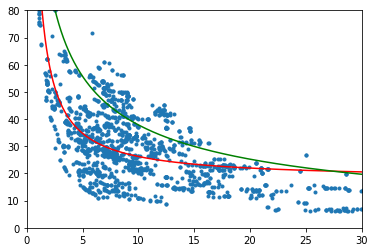

In [6]:
fig = plt.figure()
ax = plt.subplot(111)
plt.scatter(x=EROI, y=p, marker = '.')
plt.plot(EROI_for_prediction, p_predicted, color='r')
plt.plot(EROI_for_prediction, np.power(log_p_predicted, 10)-1, color='g')
ax.set_xlim(0, 30)
ax.set_ylim(0, 80)

In [23]:
themis['BL'][2010].erois(recompute=True)

/home/adrien/anaconda3/lib/python3.5/site-packages/pymrio-0.3.6-py3.5.egg/pymrio/tools/iofunctions.py:463: RuntimeWarning: invalid value encountered in true_divide
  if self.name != 'Cecilia' and var != 'Total Energy supply':


wind onshore      9.4
wind offshore     9.3
solar PV          9.2
coal             12.6
oil               8.2
gas              13.7
nuclear          10.4
hydro            13.1
coal w CCS        NaN
gas w CCS         NaN
biomass&Waste    11.3
biomass w CCS     NaN
ocean             5.5
geothermal        5.3
solar CSP        21.5
Power sector     12.1
dtype: float64

In [ ]:
def embodied_impact(self, secs=None, regs=None, var='Total Energy supply', source='secondary', group_by='region', sort=False, production = None):
    '''
    Returns a vector of impact of type var embodied in the production of (sec, reg) in secs x regs, excluding their own production, and including only impacts
    from sectors in energy_sectors(source). Results are grouped by group_by (default: region) and can be sorted in decreasing order (default: unsorted).
    '''
    secs, regs = self.prepare_secs_regs(secs, regs) # TODO: source = None
    if production is None: production = self.production(secs, regs)
    if var=='Total Energy supply' and self.name != 'Cecilia':
        impacts = self.secondary_energy_supply * (self.embodied_prod(secs, prod=production) - production)
        impacts = pd.Series(impacts, index = pd.MultiIndex.from_arrays([self.labels.idx_regions, self.labels.idx_sectors], names=['region', 'sector']))
    else:
        share_demand = div0(self.embodied_prod(secs, regs, production)-production, self.x)
        impacts = self.impacts(var)*share_demand        
    impacts = impacts[self.index_secs_regs(self.energy_sectors(source))]
    if sort: return(sorted_series(impacts.groupby(group_by).sum()))
    else: return(impacts.groupby(group_by).sum())    
    
IOS.embodied_impact = embodied_impact

In [22]:
def energy_required(self, secs, regs=None, var='Total Energy supply', source='secondary', netting_fuel = True):
    '''
    Returns the energy required to produce one unit of energy in sectors secs in regs, considering the energy from source with notion var, and 
    decomposed according to the sources in partition_sources.
    
    The formula is: 
    (energy embodied in production (excluding supplied) - fuels as direct inputs for electricity from hydrocarbon (if netting_fuel is True)) / energy supplied
    '''
    if len(secs)==1: secs = secs[0]
    sec_string = type(secs)==str or type(secs)==np.str_
    if netting_fuel and ((sec_string and secs in self.energy_sectors('elec_hydrocarbon')) \
                         or secs==self.energy_sectors('elec_hydrocarbon') or secs==self.energy_sectors('electricities')): input_fuel=True
    else: input_fuel = 0 # We want to include fuels that are used for transportation, not transformed into electricity (this is not secondary anymore)
    secs, regs = self.prepare_secs_regs(secs, regs)
    if self.name != 'Cecilia' and var != 'Total Energy supply': 
        print('GER not implemented for var of type ' + var + ", doing it for 'Total Energy supply' instead")
        var = 'Total Energy supply'
    prod = self.production(secs, regs)
    embodied = self.embodied_impact(secs, regs, var, source, production = prod).sum()
    if input_fuel:
        if self.name == 'Cecilia': input_fuel = self.inputs(secs, var_impacts=[var], \
            source=inter_secs(self.energy_sectors('secondary_fuels'), self.energy_sectors(source)), order_recursion=2)[2][0][1]
        elif secs==self.energy_sectors('electricities'): 
            prod_fuel = self.production(self.energy_sectors('elec_hydrocarbon'), regs)
            input_fuel = ((self.secondary_fuel_supply * self.A.dot(prod_fuel))[self.index_secs_regs(self.energy_sectors(source))]).sum()
        else: input_fuel = ((self.secondary_fuel_supply * self.A.dot(prod))[self.index_secs_regs(self.energy_sectors(source))]).sum()
    return(embodied - input_fuel)

IOS.energy_required = energy_required

In [25]:
eroi_tot = dict()
for s in ['BL', 'BM', 'REF', 'ER', 'ADV', 'combo']: 
    eroi_tot[s] = dict()
    for y in [2010, 2030, 2050]: eroi_tot[s][y] = themis[s][y].ger(themis[s][y].energy_sectors('electricities'))

In [26]:
eroi_tot

{'ADV': {2010: 11.9, 2030: 8.1, 2050: 5.8},
 'BL': {2010: 12.1, 2030: 10.8, 2050: 10.6},
 'BM': {2010: 12.1, 2030: 9.0, 2050: 8.0},
 'ER': {2010: 11.9, 2030: 8.3, 2050: 5.9},
 'REF': {2010: 11.9, 2030: 10.6, 2050: 10.0},
 'combo': {2010: 7.2, 2030: 7.5, 2050: 11.5}}

In [ ]:
res = results(themis, scenarios = scenarios+scenarios_dlr, not_all_2010=False, rounded=False)
erois_as_mean = dict()
for s in scenarios+scenarios_dlr:
    erois_as_mean[s] = dict()
    for y in years:
        erois_as_mean[s][y] = round(1/sum((res[(s, y, 'mix')]/res[(s, y, 'EROI')].replace('–', float('Inf')))[:-1]), 1)
erois_as_mean

In [ ]:
# average price of PV
(themis['BL'][2010].eroi_price.loc[[(r, 'Electricity by solar PV') for r in themis['BL'][2010].regions]]['price']*themis['BL'][2010].secondary_energy_demand[themis['BL'][2010].index_secs_regs('Electricity by solar PV')]).sum()/themis['BL'][2010].secondary_energy_demand[themis['BL'][2010].index_secs_regs('Electricity by solar PV')].sum()
(themis['BL'][2050].eroi_price.loc[[(r, 'Electricity by solar PV') for r in themis['BL'][2010].regions]]['price']*themis['BL'][2050].secondary_energy_demand[themis['BL'][2010].index_secs_regs('Electricity by solar PV')]).sum()/themis['BL'][2050].secondary_energy_demand[themis['BL'][2010].index_secs_regs('Electricity by solar PV')].sum()
(themis['ADV'][2050].eroi_price.loc[[(r, 'Electricity by solar PV') for r in themis['BL'][2010].regions]]['price']*themis['BL'][2050].secondary_energy_demand[themis['BL'][2010].index_secs_regs('Electricity by solar PV')]).sum()/themis['ADV'][2050].secondary_energy_demand[themis['BL'][2010].index_secs_regs('Electricity by solar PV')].sum()